In [1]:
import sys; sys.path.insert(0, "C:/GIT/python-local/pygeostat_freeze/")
sys.path.insert(0, '../')
import mkl; mkl.set_num_threads(1)
import pygeostat as gs
import gglib as gg
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
import rmutils as rm
from collections import OrderedDict
import numba
from gglib.datamgmt.simpleio import *
%matplotlib inline

The imports are copied to the clipboard


In [2]:
rm.mpl_setup()
rm.PYGSDEFAULTS['figsize'] = (6, 4)

# functions

In [3]:
import validator.crossval3 as cv
import validator._validationfuncs as vf

In [4]:
from _oilsands_project_defs import *
points = gg.PointContainer('oilsands_maincats.dat')
opoints = gg.PointContainer('oilsands_maincats.dat')
workdir = 'L:/Thesis/Ch6/oilsands_okestimation/'
gs.ensure_path(workdir)
masterseed = 10

print('\nGriddef: ')
print(griddef)
print(griddef.count())


Griddef: 
84 577.41 40.0 
152 5020.7 40.0 
75 137.5 2.0
957600


In [5]:
# clip the domain to make testing faster
indexes = (points['North'] < 7500) & (points['Elevation'] > 175)
points.data = points.loc[indexes]
griddef = points.infergriddef(25, 25, 35, (100, 100, 5))
griddef.change_blocksize(40, 40, 3)
print(griddef)

88 487.40999999999997 40.0 
67 4930.7 40.0 
34 173.0 3.0


In [6]:
points.writefile('oilsands_clipped.dat')

In [7]:
with open('griddef.griddef', 'w') as fh:
    fh.write(str(griddef))

# generate the k-folds

In [8]:
nfolds = 3

In [9]:
vf.spatialkfold(points, 'Bitumen', nfold=nfolds, outdir=workdir, rseed=123456)

K-Fold files generated in:
 L:/Thesis/Ch6/oilsands_test1/
Files:
 L:/Thesis/Ch6/oilsands_test1\Training01.dat
 L:/Thesis/Ch6/oilsands_test1\Training02.dat
 L:/Thesis/Ch6/oilsands_test1\Training03.dat
 L:/Thesis/Ch6/oilsands_test1\Validation01.dat
 L:/Thesis/Ch6/oilsands_test1\Validation02.dat
 L:/Thesis/Ch6/oilsands_test1\Validation03.dat


In [10]:
foldfile = gg.PointContainer(workdir + 'spatialkfold.out')

In [11]:
foldfile.writefile('test.vtk')

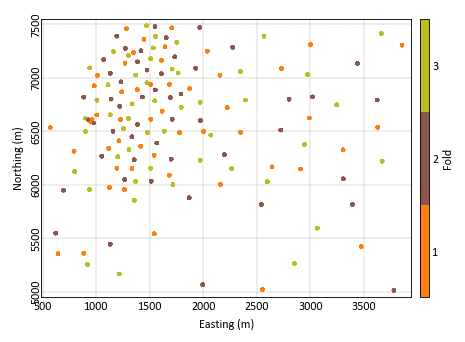

In [12]:
gs.locmap(foldfile, var=foldfile.columns[-1], cmap='tab10', cbar_label='Fold', rotateticks=(0, 90), 
          figsize=(4, 4), s=4)
rm.thesis_export('oilsands_kfold_config.pdf', chap=6)

# other parameters

## variograms

In [26]:
catvarmodels = gg.load_pickle('oilsands_catvarmodels.pkl')
nsvarmodels = gg.load_pickle('oilsands_nsvarmodels.pkl')
ouvarmodels = gg.load_pickle('oilsands_ouvarmodels.pkl')

## specs

In [24]:
variables = variables
declus_cellsize = 250
saveplots = True
masterseed = 21813
rng = np.random.RandomState(masterseed)
seeds = rng.permutation(500)
ltrim = -999
searchparams = (0, 0, 0, 2000, 2000, 50)
nprocesses = 7
nreal = 100

## clipping boundaries

In [15]:
boundct = vf.genkeyout_buffer(points, griddef, workdir, (0, 0, 0, 10, 10, 2), 75)
boundct.info()

GridContainer: L:/Thesis/Ch6/oilsands_test1/oilsands_clipped_keyout.dat
No Special Attributes Found 

Grid Definitions:
88 487.40999999999997 40.0 
67 4930.7 40.0 
34 173.0 3.0

Unused Columns:
['key']


In [16]:
np.count_nonzero(boundct['key'])

38975

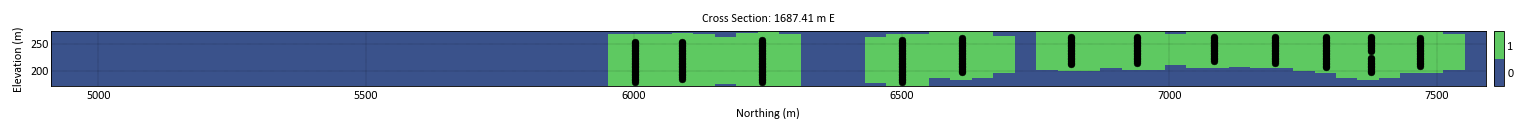

In [17]:
ax = gs.pixelplt(boundct.data, griddef, pointdata=points, pointtol=1.5, sliceno=30, orient='yz', 
                 figsize=(15, 3))

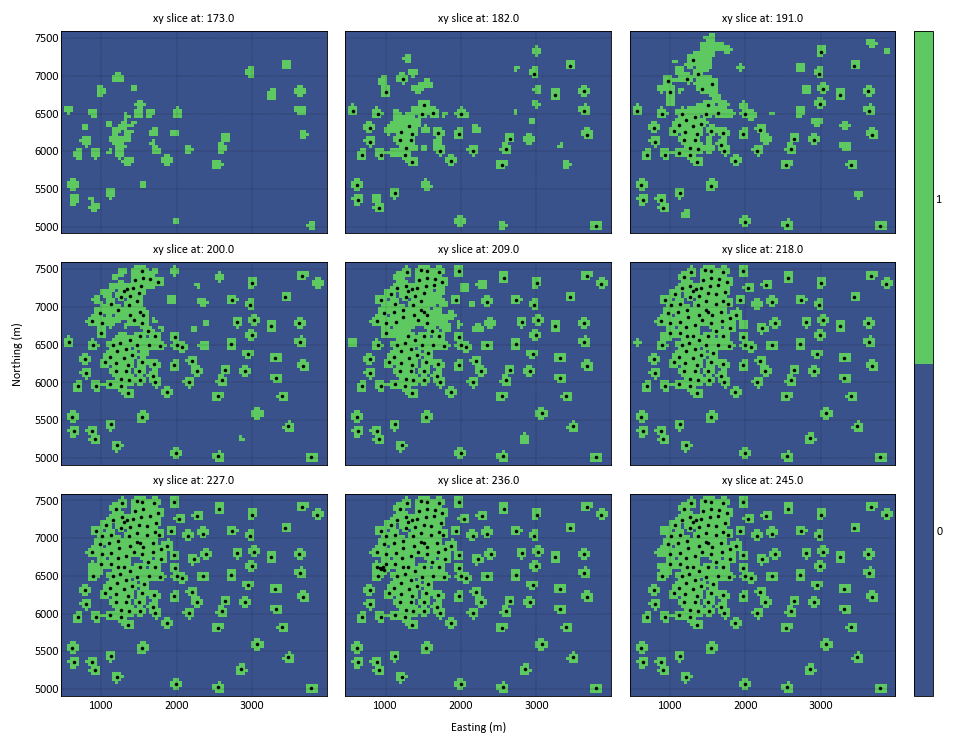

In [18]:
fig = gs.gridslicer(boundct.data, griddef, nslice=9, pointdata=points, pointtol=0.5, point_kws={'s': 3}, 
                    figsize=(9, 9), orient='xy')

# GEOSTATS
    - decluster, despike, nstransform
    - variograms, cat and continuous
    - simulation, categorical and continuous
    - backtransform and post-processings
    - validation stuff

# single-cats

In [32]:
t1 = time.time()
iseed = 0
catcols = ['modelcats', 'nodomains', 'mvclus', 'agglom', 'betteragglom']
catcols = ['modelcats']
ifolds = np.arange(nfolds, dtype=int) + 1
ifolditerator = [(ifold, catcol) for ifold in ifolds for catcol in catcols]
for iseed, (ifold, catcol) in enumerate(ifolditerator):
    dtime = time.time()
    trainct = gg.PointContainer(f'{workdir}Training{ifold:02}.dat')
    testct = gg.PointContainer(f'{workdir}Validation{ifold:02}.dat')
    ### RUN CROSSVAL
    try:
        cv.domainfold(ifold, catcol, workdir, trainct, testct, boundct, griddef, variables, 
                      catvarmodels, ouvarmodels, declus_cellsize,
                      seeds[iseed], ltrim, nreal, searchparams, 
                      nprocesses, saveplots, trenddist=1000)
    except KeyboardInterrupt:
        raise
    except: 
#         rm.notifydone(f"oilsands: ERROR on {ifold}, {catcol}")
        raise
    print(f'Finished fold {catcol} {ifold}\n'
          f'  fold elapsed:  {(time.time()-dtime)/60:.4f} min\n'
          f'  total elapsed: {(time.time()-t1)/60:.4f} min')
    plt.close()
    import gc; gc.collect()
print('Crossval finished in {} hours'.format((time.time() - t1) / 3600))

Finished fold modelcats 1
  fold elapsed:  0.2379 min
  total elapsed: 0.2379 min
Finished fold modelcats 2
  fold elapsed:  0.2364 min
  total elapsed: 0.4767 min
Finished fold modelcats 3
  fold elapsed:  0.1801 min
  total elapsed: 0.6588 min
Crossval finished in 0.011005488104290433 hours


# multi-cats

In [ ]:
t1 = time.time()
iseed = 0
realscatcols = [[f'clusreal{i}' for i in range(nreal)], 
               ]                                       # [f'randreal{i}' for i in range(nreal)]
catbases = ['reals_ensbest']                           # , 'reals_random'
ifolds = np.arange(nfolds, dtype=int) + 1
for catbase, catcols in zip(catbases, realscatcols):
    for ifold in ifolds:
        dtime = time.time()
        trainct = gg.PointContainer(f'{workdir}Training{ifold:02}.dat')
        testct = gg.PointContainer(f'{workdir}Validation{ifold:02}.dat')
        ### RUN CROSSVAL
        try:
            cv.domainfold_multi(
                ifold, catbase, catcols, workdir, trainct, testct, boundct, griddef, variables, 
                catvarmodels, nsvarmodels, declus_cellsize,
                seeds[iseed], ltrim, nreal, searchparams, 
                nprocesses, saveplots)
        except KeyboardInterrupt:
            raise
        except: 
#             rm.notifydone(f"oilsands: ERROR on {ifold}, {catcol}")
            raise
        print(f'Finished fold {catbase} {ifold}\n'
              f'  fold elapsed:  {(time.time()-dtime)/60:.4f} min\n'
              f'  total elapsed: {(time.time()-t1)/60:.4f} min')
        iseed += 1
        plt.close()
        import gc; gc.collect()
print('Crossval finished in: ', (time.time() - t1) / 3600)

# validation plotting

In [ ]:
names = ['reals_ensbest', 'betteragglom', 'nodomains']
titles = ["Category Realizations", "Improved Spatial Clusters",
          "No Domains"]
names = OrderedDict([(k, t) for k, t in zip(names, titles)])

In [ ]:
valdict = {}
for var in variables:
    for name, title in names.items():
        for ifold in ifolds:
            valdict[var, name, ifold] = \
                read_gslib(f'{workdir}{name}_{var}_fold{ifold}.out').values

In [ ]:
qf = gg.QuickFormatter(fs=6.5)
for var in variables:
    acaxs = qf.getax(len(names), shape=(1, 3), figsize=(6, 1.8))
    iax = 0
    for (name, title), ax in zip(names.items(), acaxs):
        etypes = np.empty(0)
        truths = np.empty(0)
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            ids = thisdata[:, 0:1]
            xyz = thisdata[:, 1:4]
            truth = thisdata[:, 4:5].flatten()
            reals = thisdata[:, 5:]
            etype = np.mean(reals, axis=1).flatten()
            truths = np.concatenate((truths, truth))
            etypes = np.concatenate((etypes, etype))
        ax = gs.scatxval(etypes, truths, ax=ax, 
                         title=f'{var}, {title}', ms=1, pltstyle='pt5.5')
        qf(ax, fignum=iax, lblxy=(0.01, 1.05), aspect=1, nticks='auto', 
           xlim=(0, None), ylim=(0, None))
        iax += 1
    plt.subplots_adjust(hspace=0.35)
#     chapexportimg(f'oilsands_scatxval_all_{var}.pdf')

In [ ]:
accpltdict = {}
for var in variables:
    iax = 0
    for (name, title), ax in zip(names.items(), acaxs):
        probs = None
        for ifold in ifolds:
            thisdata = valdict[var, name, ifold]
            xyz = thisdata[:, :4]
            truth = thisdata[:, 4:5].flatten()
            reals = thisdata[:, 5:]
            thisaccsim, sumstats = gs.accsim(truth, reals)
            if probs is None:
                probs = thisaccsim
            else:
                probs['FracIn'] += thisaccsim['FracIn']
        accpltdict[var, name] = [probs['ProbInt'], probs['FracIn'] / nfolds, sumstats]

In [ ]:
statnames = {
    'avgvar': 'U', 
    'mse': 'MSE', 
    'acc': 'Accuracy', 
    'pre': 'Precision', 
    'goo': 'Goodness'
}

In [ ]:
for var in variables:
    acaxs = qf.getax(len(names), shape=(1, 3), figsize=(6, 1.8))
    iax = 0
    for (name, title), ax in zip(names.items(), acaxs):
        probs = accpltdict[var, name]
        ax = gs.accplt(x=probs[0], y=probs[1], ax=ax, stat_blk=False, 
                       title=f'{var}, {title}', pltstyle='pt5.5', ms=2)
        qf(ax, fignum=iax, lblxy=(0.01, 1.05), 
           annot='\n'.join([f'{statnames[k]} = {probs[2][k]:.3f}' 
                            for k in statnames.keys()]), 
           annha='left', annva='top', annxy=(0.01, 0.99),
           aspect=1, 
          )
        iax += 1
    plt.subplots_adjust(hspace=0.35)
#     chapexportimg(f'oilsands_accplt_all_{var}.pdf')